

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
import torchvision
import torch
import PIL

print('torchvision: ', torchvision.__version__) # точно работает с версией 0.8.1, 0.9.0
print('torch: ', torch.__version__) # точно работает с версией 1.7.0, 1.8.0
print('PIL: ', PIL.__version__) # точно работает с версией 7.2.0, 8.1.0

# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

torchvision:  0.9.1+cu111
torch:  1.9.1+cu102
PIL:  8.2.0
CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi

Sun Dec 19 01:14:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:42:00.0  On |                  N/A |
| 25%   29C    P8    11W / 215W |   1638MiB /  8192MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
# !pip install torchsummary
# !pip install efficientnet_pytorch

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 10)

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from torchsummary import summary
import seaborn as sns
sns.set_theme()

import copy
import pandas as pd
from sklearn.metrics import f1_score
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split

In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


### Dataset wrapper

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                    
        # расчёт весов
        if self.mode == 'train':
            label_ids = self.label_encoder.transform(self.labels).tolist()
            N = len(set(label_ids))
            weight_per_class = [0] * N
            for i in range(N):
                weight_per_class[i] = self.len_ / label_ids.count(i)
                        
            self.weights = [0.] * self.len_
            for i, label_id in enumerate(label_ids):
                self.weights[i] = weight_per_class[label_id]
            self.weights = torch.DoubleTensor(self.weights)
                
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
#                 transforms.RandomResizedCrop(224),
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#                 transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(), # augmentation
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#                 transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
#         x = self._prepare_sample(x)
#         x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
#     def _prepare_sample(self, image):
#         image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
#         return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
# TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
# TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

TRAIN_DIR = Path('data/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('data/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [12]:
# For unbalanced dataset we create a weighted sampler                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(train_dataset.weights, len(train_dataset.weights)) 

Давайте посмотрим на наших героев внутри датасета.

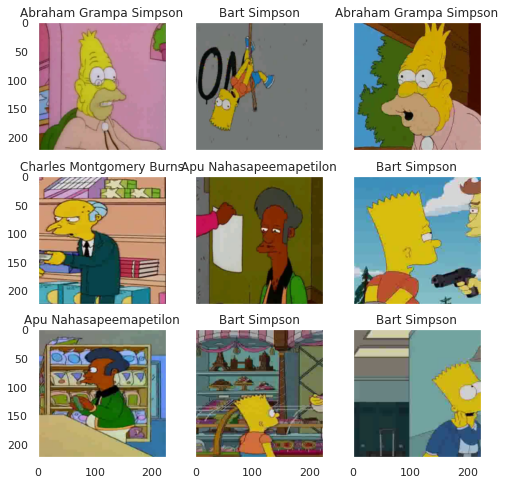

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

### Построение нейросети

In [14]:
# выбор модели

# model = models.alexnet(pretrained=True).cuda()
# model = models.vgg16(pretrained=True).cuda()
# model = models.inception_v3(pretrained=True)
# model = models.resnext101_32x8d(pretrained=True).cuda() # overfitting
model = EfficientNet.from_pretrained('efficientnet-b4')
# model = models.mobilenet_v3_large(pretrained=True)
# model = models.googlenet(pretrained=True)
model

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [15]:
# выбор классификатора и заморозка слоёв 

# layers_to_unfreeze = 32

# замораживаем параметры (веса)
# for param in model.parameters():
#     param.requires_grad = False

# model.layer4.requires_grad_(True)
# model.layer3.requires_grad_(True)

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
# num_features = 2560
# Заменяем Fully-Connected слой на наш линейный классификатор

# model.AuxLogits.fc = nn.Linear(768, 42)
# model._fc = nn.Sequential(
#     nn.Linear(1792, 512),
#     nn.Hardswish(),
#     nn.Dropout(p=0.2),
#     nn.Linear(512, 42)
# )

model._fc = nn.Linear(1792, 42)

# model.classifier[0] = nn.Linear(960, 1280)
# model.classifier[3] = nn.Linear(1280, 42)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# model._blocks[:21].requires_grad_(False)

In [16]:
# отчёт по модели; проверка корректности модели, а также перевод на GPU
summary(model.cuda(), (3, 224, 224));

Layer (type:depth-idx)                             Output Shape              Param #
├─Conv2dStaticSamePadding: 1-1                     [-1, 48, 112, 112]        --
|    └─ZeroPad2d: 2-1                              [-1, 3, 225, 225]         --
├─BatchNorm2d: 1-2                                 [-1, 48, 112, 112]        96
├─MemoryEfficientSwish: 1-3                        [-1, 48, 112, 112]        --
├─ModuleList: 1                                    []                        --
|    └─MBConvBlock: 2-2                            [-1, 24, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-1           [-1, 48, 112, 112]        432
|    |    └─BatchNorm2d: 3-2                       [-1, 48, 112, 112]        96
|    |    └─MemoryEfficientSwish: 3-3              [-1, 48, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-4           [-1, 12, 1, 1]            588
|    |    └─MemoryEfficientSwish: 3-5              [-1, 12, 1, 1]            --
|    |    └─Conv2dStaticSamePaddi

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    print('fit')
    for inputs, labels in tqdm_notebook(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    print('eval')
    for inputs, labels in tqdm_notebook(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # sampler=sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm_notebook(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    model.load_state_dict(best_model_wts)
    return history, model

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {}".format(n_classes))
# print(simple_cnn)

we will classify: 42


Запустим обучение сети.

In [ ]:
%%time
# model.aux_logits = False
history, best_model = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=10)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

fit


  0%|          | 0/1570 [00:00<?, ?it/s]

0.9629 - b0 - 3 epochs

0.9706 - b0 - hflip - 6e

0.9742 - b0 - hflip - 1e - adamw

0.9782 - b2 - 20e

Попытки освободить память GPU

In [43]:
# !gpustat -p

bbe8845246f9             Thu Apr 15 11:53:00 2021  450.51.06
[0] Tesla P100-PCIE-16GB | 38'C,   0 % | 16173 / 16280 MB |


In [51]:
# def pretty_size(size):
#     """Pretty prints a torch.Size object"""
#     assert(isinstance(size, torch.Size))
#     return " × ".join(map(str, size))

# def dump_tensors(gpu_only=True):
#     """Prints a list of the Tensors being tracked by the garbage collector."""
#     import gc
#     total_size = 0
#     for obj in gc.get_objects():
#         try:
#             if torch.is_tensor(obj):
#                 if not gpu_only or obj.is_cuda:
#                     print("%s:%s%s %s" % (type(obj).__name__, \
#                                         " GPU" if obj.is_cuda else "",\
#                                         " pinned" if obj.is_pinned else "",\
#                                         pretty_size(obj.size())))
#                     total_size += obj.numel()
#             elif hasattr(obj, "data") and torch.is_tensor(obj.data):
#                 if not gpu_only or obj.is_cuda:
#                     print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, \
#                                                     type(obj.data).__name__,\
#                                                     " GPU" if obj.is_cuda else "",\
#                                                     " pinned" if obj.data.is_pinned else "",\
#                                                     " grad" if obj.requires_grad else "", \
#                                                     " volatile" if obj.volatile else "",\
#                                                     pretty_size(obj.data.size())))
#                     total_size += obj.data.numel()
#         except Exception as e:
#             pass        
#     print("Total size:", total_size)
# dump_tensors()

In [42]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

Построим кривые обучения

In [64]:
loss, acc, val_loss, val_acc = zip(*history)

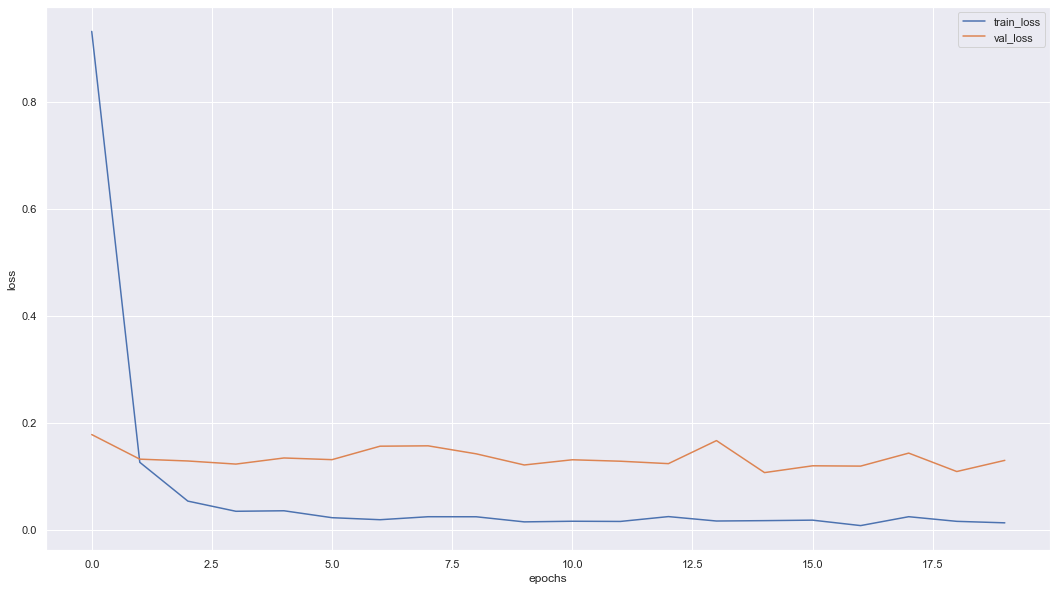

In [65]:
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

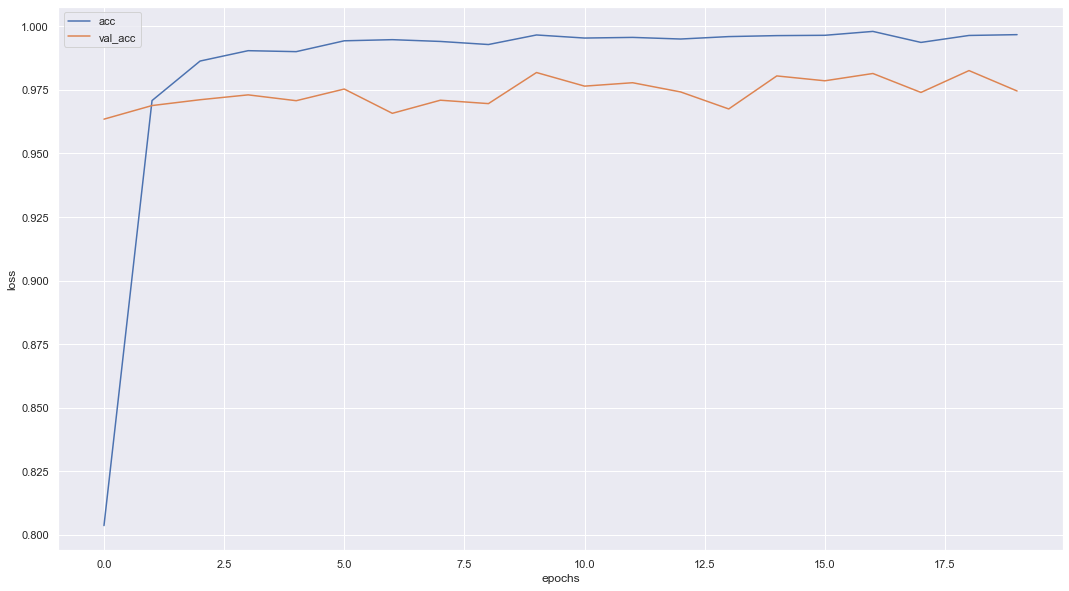

In [66]:
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [31]:
# сравним предсказание случайной картинки с реальным значением

true_label, np.argmax(probs_im, -1)

(4, array([4]))

In [33]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [47]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [36]:
y_pred

array([6, 0, 6, 4, 2, 0, 2, 0, 4, 4, 1, 6, 4, 2, 6, 0, 4, 6, 0, 2])

In [37]:
actual_labels

[6, 0, 6, 4, 2, 0, 2, 0, 4, 4, 1, 6, 4, 2, 6, 0, 4, 6, 0, 2]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [38]:
f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете использовать это, чтобы отлаживать правильность вывода.

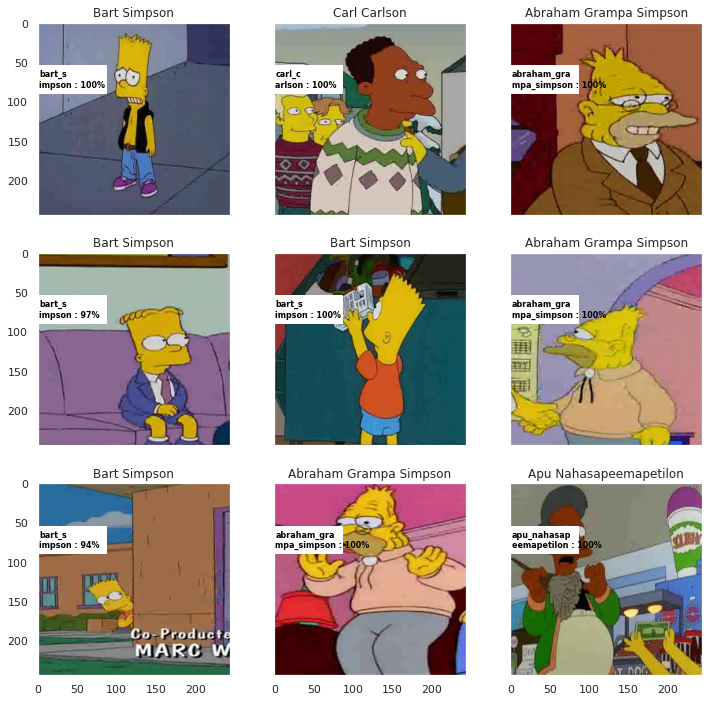

In [40]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла распознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [55]:
len(val_dataset)

5234

In [57]:
%%time
# проверка на валидации

imgs = [val_dataset[id_][0].unsqueeze(0) for id_ in range(5234)]
probs_ims = predict(best_model, imgs)

y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id_][1] for id_ in range(5234)]

f1_score(actual_labels, y_pred, average='micro')

0.9638899503247994

In [67]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [68]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [69]:
my_submit.to_csv('submit_b4_no_freeze.csv', index=False)

Некоторые результаты:

- 5 epochs
- baseline
- batchnorm
- val acc = 0.7803
- LB = 0.84484

- 8 epochs
- baseline (5 conv)
- batchnorm
- 3 fc
- val acc = 0.8030

- 2 epochs
- AlexNet
- classifier: Linear
- val acc = 0.8911

- 2 epochs
- VGG16
- classifier: Linear
- val acc = 0.9306

- 2 epochs
- Inception v3
- classifier: Linear
- val acc = 0.9524

- 2 epochs
- Eff Net b2
- classifier: Linear
- val acc = 0.9582

- 3 epochs
- Eff Net b2
- classifier: Linear
- val acc = 0.9639

- 4 epochs
- batchsize 16
- aug data
- Eff Net b2
- classifier: Linear
- val acc = 0.9824
- LB acc = 0.98724

- 18 epochs
- batchsize 16
- aug hflip
- Eff Net b4
- classifier: Linear
- val acc = 0.9799
- LB acc = 0.99574
- 5 blocks frozen

- 19 epochs
- batchsize 16
- aug hflip
- Eff Net b4
- classifier: Linear
- val acc = 0.9826
- LB acc = 0.99787

- 19 epochs
- batchsize 32 (kaggle)
- aug hflip
- Eff Net b5
- classifier: Linear
- val acc = 0.9765

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочных улучшений для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
# model = models.alexnet(pretrained=True).cuda()
# model = models.vgg16(pretrained=True).cuda()
# model = models.inception_v3(pretrained=True)
# model = models.resnext101_32x8d(pretrained=True).cuda() # overfitting
model = EfficientNet.from_pretrained('efficientnet-b5')
# model = models.mobilenet_v3_large(pretrained=True)
# model = models.googlenet(pretrained=True)

## Заключение

Выбор модели:

Были опробованы сеть SimpleCNN и её модификации. 

После были опробован Transfer Learning предобученных сетей:
- AlexNet
- VGG16
- Inception v3
- ResNext
- MobileNet v3 Large
- GoogLeNet
- Efficient Net
    - b0
    - b1
    - b2
    - b3
    - b4
    - b5

Наиболее высокие результаты показали предобученные сети. Результаты сравнимы между собой: 0.96-0.99

По итогам тестов на Kaggle наивысший результат показала сеть Efficient Net b4. Более мощные b5-b7 показали меньший скор при увеличенном времени обучения (b5 - 20 эпох - 3 часа) и используемой памяти GPU (пришлось сильно уменьшать batch size).

- Efficient Net b4
- lr 1e-4
- AdamW
- batchsize 16
- 20 эпох (максимальный скор достигнут на 18 эпохе)
- аугментация данных (горизонтальный переворот изображений с вероятностью 50%)

Сеть использовалась предобученная, слои не замораживались, слой классификатора fc был заменён на линейный слой с соответствующим количеством выходов под количество классов 42

Проверенные идеи, которые не привели к увеличению скора:

- заморозка слоёв
- использование многослойного классификатора (https://arxiv.org/abs/1902.02771)
- балансировка классов весами

Точность:
- val acc 0.9826
- leader board acc 0.99787